In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader

In [42]:
! pip install fix-yahoo-finance==0.1.30

In [43]:
! pip install yfinance
import yfinance as yf

In [44]:
yf

<module 'yfinance' from '/usr/local/lib/python3.7/dist-packages/yfinance/__init__.py'>

In [45]:
stock_of_choice = yf.Ticker('AMZN')


In [46]:
# pip install streamlit fbprophet yfinance plotly
# from fbprophet import Prophet
# from fbprophet.plot import plot_plotly
# from plotly import graph_objs as go

In [47]:
data_x = yf.download('AMZN')

[*********************100%***********************]  1 of 1 completed


In [48]:
data_x.index

DatetimeIndex(['1997-05-15', '1997-05-16', '1997-05-19', '1997-05-20',
               '1997-05-21', '1997-05-22', '1997-05-23', '1997-05-27',
               '1997-05-28', '1997-05-29',
               ...
               '2022-02-07', '2022-02-08', '2022-02-09', '2022-02-10',
               '2022-02-11', '2022-02-14', '2022-02-15', '2022-02-16',
               '2022-02-17', '2022-02-18'],
              dtype='datetime64[ns]', name='Date', length=6234, freq=None)

In [49]:
data_x.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [50]:
type(data_x)

pandas.core.frame.DataFrame

In [51]:
data_x['% Returns'] = data_x.Close.pct_change() # we find the percentage change using the pct_change() method
data_x['Log returns'] = np.log(1 + data_x['% Returns']) # from the percentage returns we can easily compute log returns
data_x.dropna(inplace=True) # We drop all null/NaN values so that we do not get a value error

In [52]:
data_x.head()

,Open,High,Low,Close,Adj Close,Volume,% Returns,Log returns
Date,,,,,,,,
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,-0.117021,-0.124454
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,-0.012049,-0.012122
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,-0.042683,-0.043620
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,-0.127389,-0.136265
1997-05-22,1.437500,1.447917,1.312500,1.395833,1.395833,11776800,-0.021898,-0.022141


In [53]:
import matplotlib.pyplot as plt

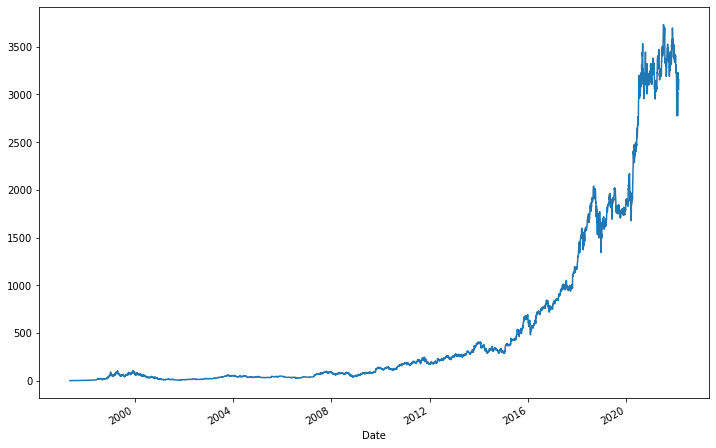

In [54]:
data_x['Close'].plot(figsize=(12,8))

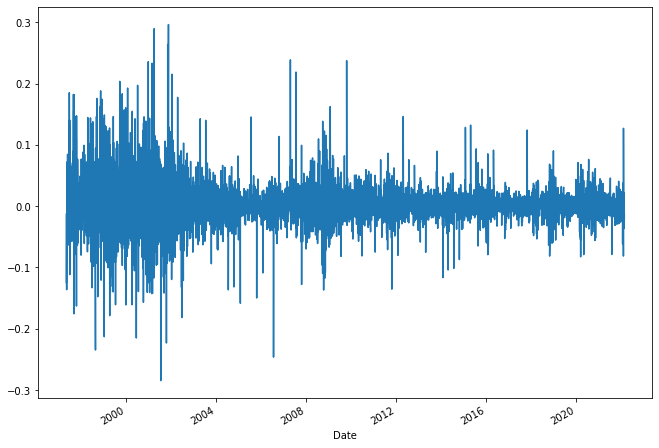

In [55]:
data_x['Log returns'].plot(figsize=(11,8))

In [56]:
x = data_x[['Close','Log returns']]

In [57]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)).fit(x)
x_scaled = scaler.transform(x)

In [58]:
y = [x[0] for x in x_scaled]

In [59]:
split_point = int(len(x_scaled)*0.8)
split_point

4986

In [60]:
X_train = x_scaled[:split_point]
y_train = y[:split_point]
X_test = x_scaled[split_point:]
y_test = y[split_point:]

In [61]:
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

In [62]:
time_step = 3 # the time step for the LSTM model
Xtrain = []
ytrain = []
Xtest = []
ytest = []
for i in range(time_step,len(X_train)):
  Xtrain.append(X_train[i-time_step:i,:X_train.shape[1]]) # we want to use the last 3 days’ data to predict the next day
  ytrain.append(y_train[i])
for i in range(time_step, len(y_test)):
  Xtest.append(X_test[i-time_step:i,:X_test.shape[1]])
  ytest.append(y_test[i])


The input structure of the LSTM architecture:
- Number of observations
- time steps
- number of Features per step

In [63]:
np.array(Xtrain).shape #We check for the shape of out train data

(4983, 3, 2)

In [64]:
Xtrain, ytrain = np.array(Xtrain), np.array(ytrain)
Xtrain = np.reshape(Xtrain,(Xtrain.shape[0],Xtrain.shape[1],Xtrain.shape[2]))
Xtest, ytest = np.array(Xtest), np.array(ytest)
Xtest = np.reshape(Xtest,(Xtest.shape[0],Xtest.shape[1],Xtest.shape[2]))

In [65]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
# the input shape comprises the time step and the number of obsevations
model = Sequential()

model.add(LSTM(10,input_shape=(Xtrain.shape[1],Xtrain.shape[2])))

model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(
  Xtrain,
  ytrain,
  epochs=100,
  validation_data=(Xtest,ytest),
  batch_size=16,
  verbose=1)

Epoch 1/100
312/312 [==============================] - 5s 7ms/step - loss: 5.8820e-04 - val_loss: 5.5867e-04
Epoch 2/100
312/312 [==============================] - 1s 4ms/step - loss: 8.0359e-06 - val_loss: 3.0165e-04
Epoch 3/100
312/312 [==============================] - 2s 6ms/step - loss: 4.5837e-06 - val_loss: 2.6978e-04
Epoch 4/100
312/312 [==============================] - 2s 8ms/step - loss: 3.2465e-06 - val_loss: 4.2420e-04
Epoch 5/100
312/312 [==============================] - 2s 7ms/step - loss: 3.0502e-06 - val_loss: 7.8337e-04
Epoch 6/100
312/312 [==============================] - 2s 8ms/step - loss: 2.6829e-06 - val_loss: 7.2458e-04
Epoch 7/100
312/312 [==============================] - 2s 7ms/step - loss: 2.8527e-06 - val_loss: 0.0011
Epoch 8/100
312/312 [==============================] - 2s 7ms/step - loss: 2.8509e-06 - val_loss: 0.0015
Epoch 9/100
312/312 [==============================] - 2s 7ms/step - loss: 2.9030e-06 - val_loss: 0.0019
Epoch 10/100
312/312 [=========

# Prediction phase

In [66]:
train_predict = model.predict(Xtrain)
test_predict = model.predict(Xtest)

### Here we are concatenating with an array of zeros since we know that our scaler requires a 2D input

In [67]:
train_predict = np.c_[train_predict,np.zeros(train_predict.shape)]
test_predict = np.c_[test_predict,np.zeros(test_predict.shape)]

### To obtain the values on the right scale, we have to inverse transform the data

In [68]:
# to obtain the values on the right scale, we have to inverse transform the data
train_predict = scaler.inverse_transform(train_predict)
train_predict = [x[0] for x in train_predict]

test_predict = scaler.inverse_transform(test_predict)
test_predict = [x[0] for x in test_predict]

In [69]:
print(train_predict[:5])
print(test_predict[:5])

[-0.10202828925769768, -1.6319167200629845, -0.19658247788833247, 0.23495564642308853, -0.6569374600791424]
[850.4776848086246, 851.0969187574393, 851.1586698495436, 850.3305604694709, 854.5967216526025]


In [70]:
from sklearn.metrics import mean_squared_error

train_score = mean_squared_error([x[0][0] for x in Xtrain],train_predict, squared=False)
print('Train score: {}'.format(train_score))

test_score = mean_squared_error([x[0][0] for x in Xtest],test_predict,squared=False)
print('Test score: {}'.format(test_score))

Train score: 245.30330733636356
Test score: 2204.2157856358513


In [82]:
#print(test_predict[:5])
# generating the original btc price sequence
original_stock_price[:5]

[852.4600219726562,
 854.5900268554688,
 852.530029296875,
 852.969970703125,
 853.4199829101562]

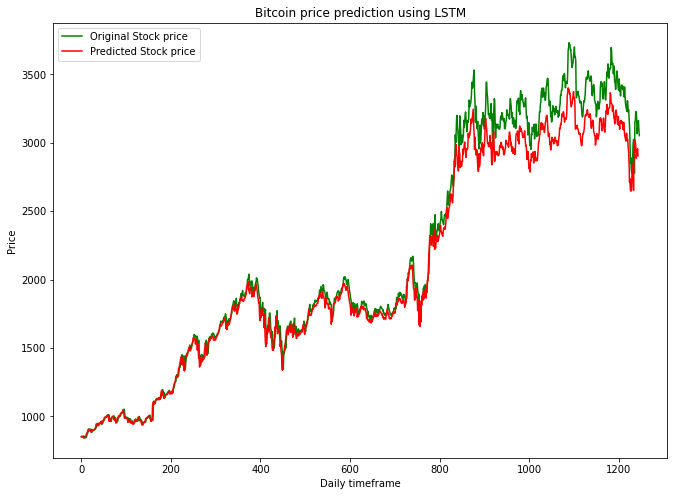

In [84]:
# We now try to visualize our prediction along with the original data in order to see how well it performed!
plt.figure(figsize=(11,8))
plt.plot(original_stock_price,color='green',label='Original Stock price')
plt.plot(test_predict,color='red',label='Predicted Stock price')
plt.title('Bitcoin price prediction using LSTM')
plt.xlabel('Daily timeframe')
plt.ylabel('Price')
plt.legend()
plt.show()

In [86]:
print('Mic check 1..2..')
model.save('keras_model.h5')

Mic check 1..2..
